This based off of the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

And heavily influenced by https://github.com/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

# Analysis for PBMC1 10x

In [114]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib.pyplot import rc_context

import os
import collections

res_name = "pbmc10x_rep1"
exp_str = "pbmc1"
method_str = "10x Chromium (v2) A"

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# we are working with PBMCs so lets store some marker genes
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

marker_genes_dict = {
    'CD14 Mono': ['CD14', 'LYZ'],
    'CD16 Mono': ['FCGR3A', 'MS4A7'],
    'Dendritic': ['FCER1A', 'CST3'],
    'NK': ['GNLY', 'NKG7', 'KLRB1'],
    'B Cell': ['CD79A', 'MS4A1'],
    #'Plasma': ['IGJ'],
    'CD4 T': ['IL7R'],
    'CD8 T': ['CD8A', 'CD8B'],
    'Megakaryocytes': ['PPBP']
}

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.19.5 scipy==1.7.1 pandas==1.3.3 scikit-learn==1.0 statsmodels==0.13.0 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


## Open files

In [115]:
data_path = f"{os.getcwd()}/../../data/single_cell_data/GSE132044/10x_hg19/"

results_file = f"{data_path}/{res_name}.h5ad"

adata = sc.read_10x_mtx(
    data_path,                               # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`


... reading from cache file cache/beevol-home-davidson-checkouts-sc_bulk_ood-evaluation_experiments-pbmc-..-..-data-single_cell_data-GSE132044-10x_hg19-matrix.h5ad


In [116]:
# make cell type specific marker annotation

genes_annot_dict = {
    'CD14': ['CD14 (CD14 Mono)'],
    'LYZ': ['LYZ (CD14 Mono)'],
    'FCGR3A': ['FCGR3A (CD16 Mono)'],
    'MS4A7': ['MS4A7 (CD16 Mono)'],
    'FCER1A': ['FCER1A (Dendritic)'],
    'CST3': ['CST3 (Dendritic)'],
    'GNLY': ['GNLY (NK)'],
    'NKG7': ['NKG7 (NK)'],
    'MS4A1': ['MS4A1 (B)'],
    'IL7R': ['IL7R (CD4T)'],
    'CCR7': ['CCR7 (Naive CD4T)'],
    'S100A4': ['S100A4 (Memory CD4T)'],
    'CD8A': ['CD8A (CD8 T)'],
    'PPBP': ['PPBP (Megak)']
}

# Initialize empty column in cell metadata
adata.var['gene_annot'] = adata.var_names

# Generate new assignments
for i in genes_annot_dict.keys():
    ind = np.where(pd.Series(adata.var_names).isin([i]))[0]
    adata.var['gene_annot'].iloc[ind] = genes_annot_dict[i]
adata.var['gene_annot'].iloc[ind]

PPBP    PPBP (Megak)
Name: gene_annot, dtype: object

In [117]:
# add metadata
meta_cols = ['code', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method']
barcodes = pd.read_csv(f"{data_path}/barcodes.tsv", header=None, names=['code'])
meta_data = pd.read_csv(f"{data_path}/GSE132044_meta.txt", skiprows=2, names=meta_cols, index_col='code', sep="\t")
meta_df = barcodes.join(other=meta_data, on=['code'], how='left', sort=False)

adata.obs['CellType'] = meta_df['CellType'].tolist()
adata.obs['Experiment'] = meta_df['Experiment'].tolist()
adata.obs['Method'] = meta_df['Method'].tolist()
meta_df

code   nGene     nUMI  \
0                          pbmc1_Celseq2_1_ACAGAC  3290.0   9030.0   
1                          pbmc1_Celseq2_1_ACAGGA  2797.0   8482.0   
2                          pbmc1_Celseq2_1_ACGTTG  2651.0   6787.0   
3                          pbmc1_Celseq2_1_AGACCA  2766.0   6004.0   
4                          pbmc1_Celseq2_1_CAACTC  3510.0  10162.0   
...                                           ...     ...      ...   
44428  pbmc2_inDrops_1_TAGTCTCT.GAGCCTTA.ATCCGCTA   453.0    717.0   
44429  pbmc2_inDrops_1_TCCAGAAG.TTATGCGA.TAAGACGG   592.0    938.0   
44430  pbmc2_inDrops_1_TGAATCCT.GAGCCTTA.CCCAAGCA   406.0    662.0   
44431  pbmc2_inDrops_1_TGAATCCT.TTATGCGA.CATCTCCC  1001.0   2066.0   
44432  pbmc2_inDrops_1_TGAGCACA.GAGCCTTA.CGAGTCTG   184.0    253.0   

       percent.mito  Cluster                     CellType Experiment    Method  
0          0.090255      1.0                  CD4+ T cell      pbmc1  CEL-Seq2  
1          0.116954      1.0                  CD4+ T cell      pbmc1  CEL-Seq2  
2          0.111979      1.0                  CD4+ T cell      pbmc1  CEL-Seq2  
3          0.093271      1.0                  CD4+ T cell      pbmc1  CEL-Seq2  
4          0.116217      1.0                  CD4+ T cell      pbmc1  CEL-Seq2  
...             ...      ...                          ...        ...       ...  
44428      0.097629     11.0  Plasmacytoid dendritic cell      pbmc2   inDrops  
44429      0.035181     11.0  Plasmacytoid dendritic cell      pbmc2   inDrops  
44430      0.138973     11.0  Plasmacytoid dendritic cell      pbmc2   inDrops  
44431      0.055663     11.0  Plasmacytoid dendritic cell      pbmc2   inDrops  
44432      0.146245     11.0  Plasmacytoid dendritic cell      pbmc2   inDrops  

[44433 rows x 8 columns]

## Preprocessing

In [118]:
# lets see whats in adata
adata

AnnData object with n_obs × n_vars = 44433 × 33694
    obs: 'CellType', 'Experiment', 'Method'
    var: 'gene_ids', 'gene_annot'

In [119]:
# filter it for only our method and experiment
adata = adata[adata.obs["Experiment"] == exp_str, :]
adata = adata[adata.obs["Method"].isin([method_str, "10x Chromium (v2) B"]), :]

adata

View of AnnData object with n_obs × n_vars = 6444 × 33694
    obs: 'CellType', 'Experiment', 'Method'
    var: 'gene_ids', 'gene_annot'

normalizing counts per cell
    finished (0:00:00)


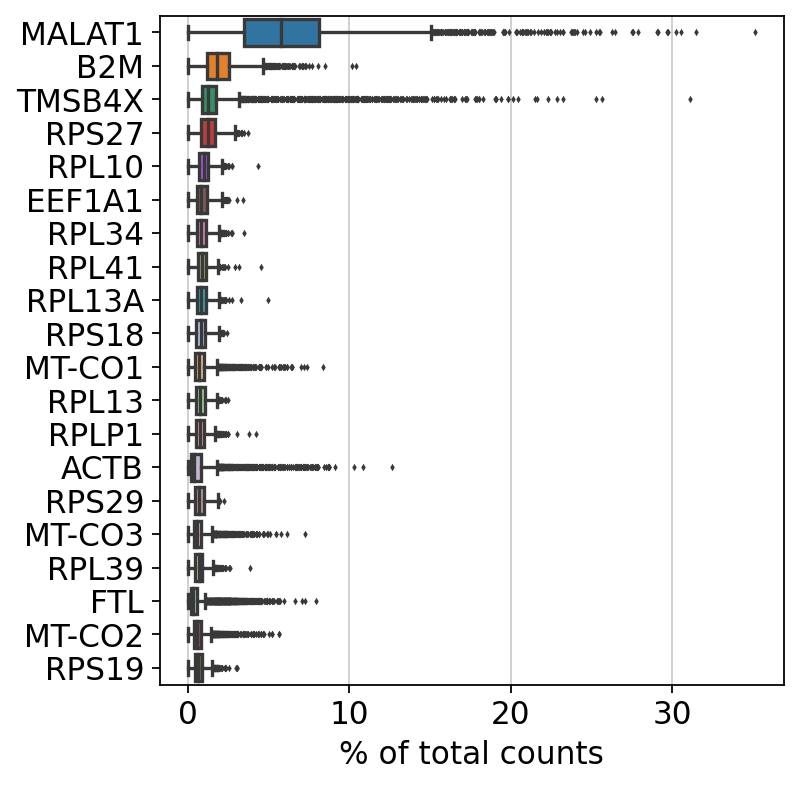

In [120]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [121]:
# filter out cells with less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=5)


filtered out 1027 cells that have less than 500 genes expressed
filtered out 16955 genes that are detected in less than 5 cells


... storing 'CellType' as categorical
... storing 'Experiment' as categorical
... storing 'Method' as categorical


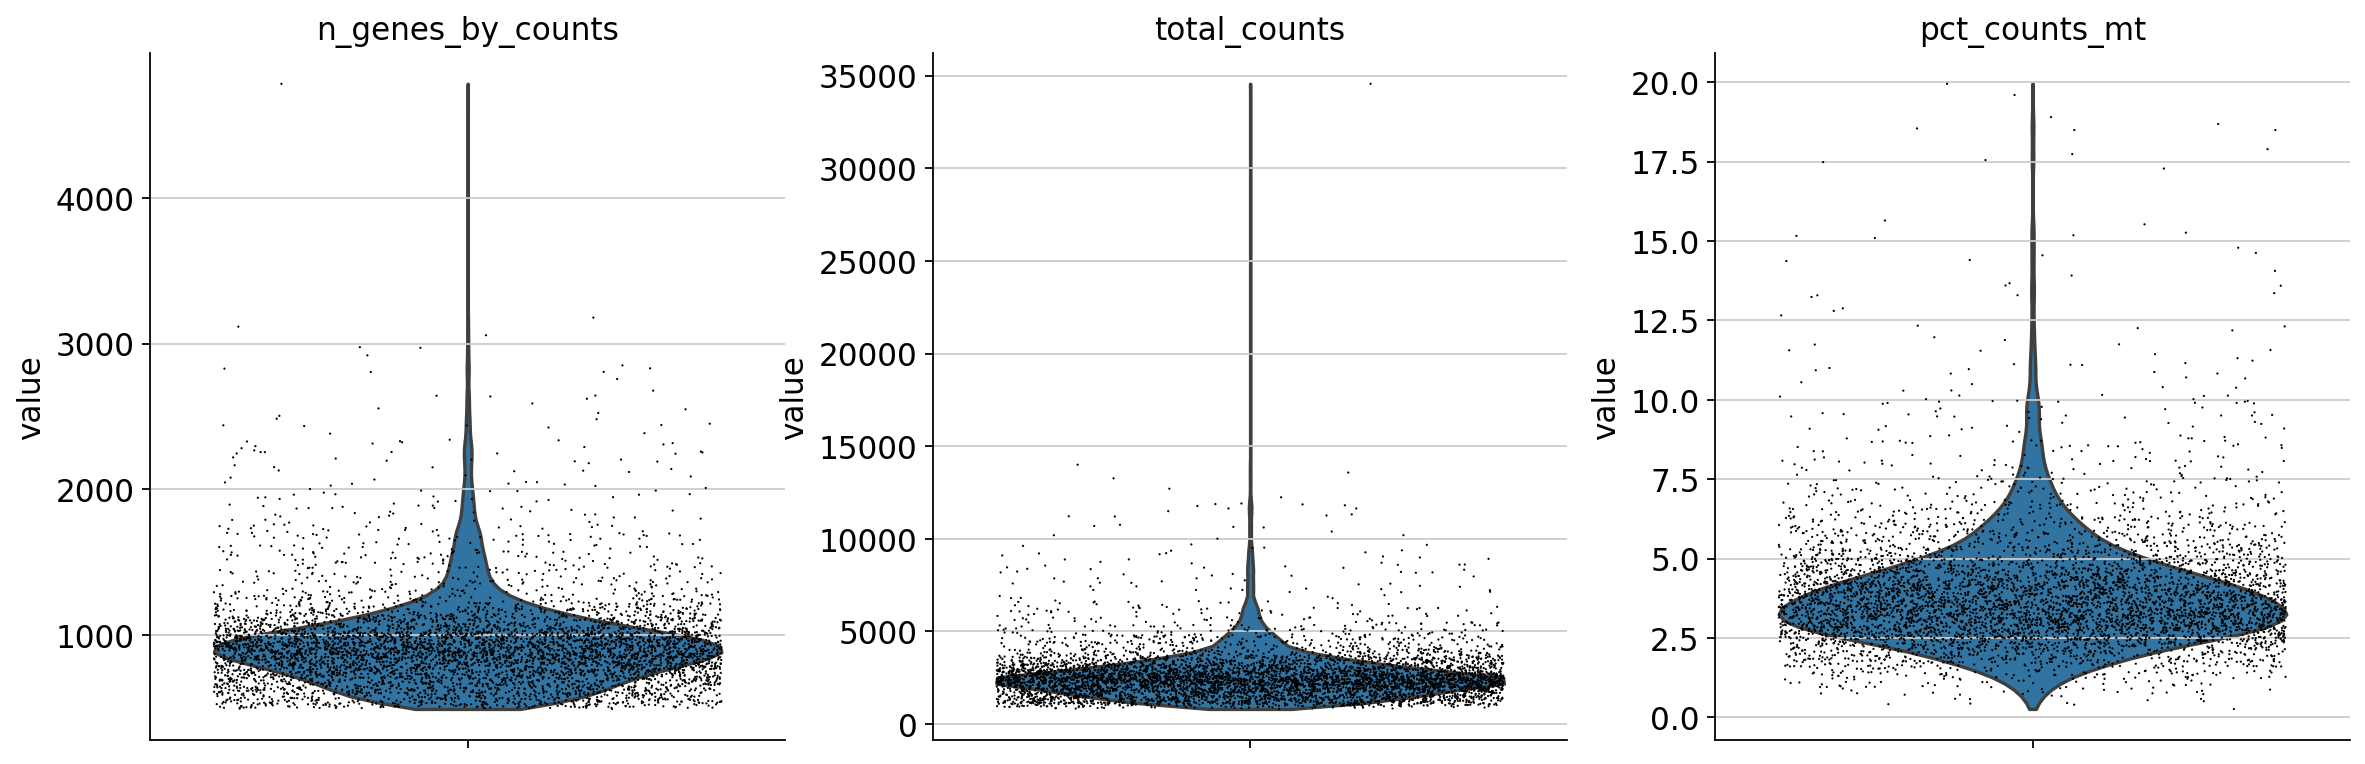

In [122]:
# remove genes with high mitochondrial content
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

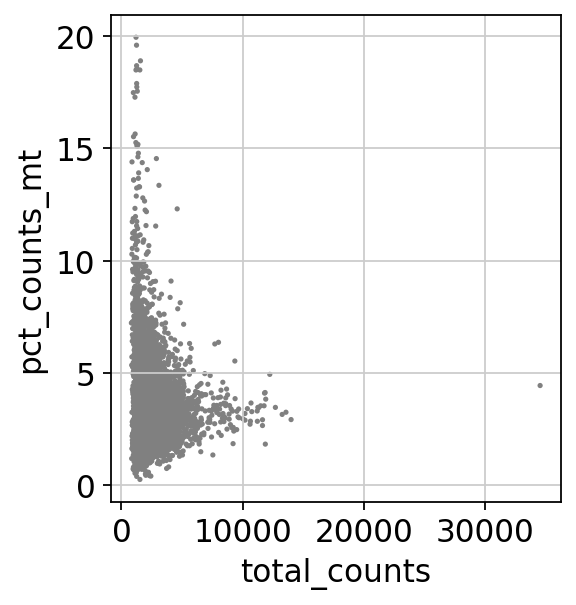

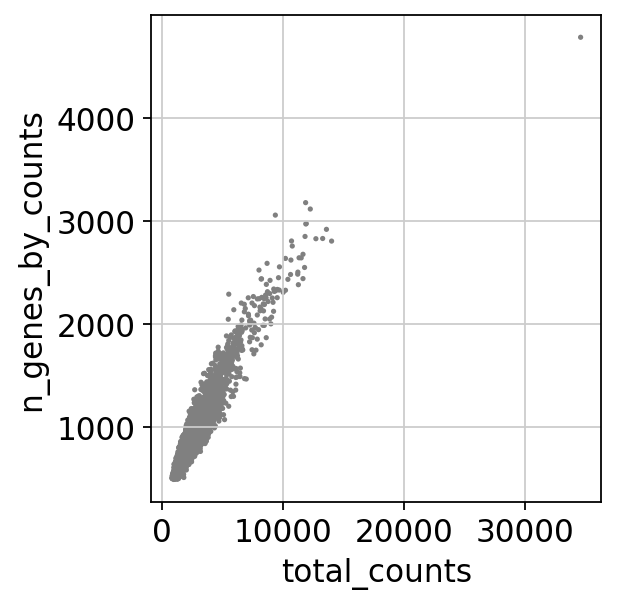

In [123]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [124]:
# slice the data based on the plots from above
# remove cells with more than 2500 genes
# remove cells with more than 5% MTgenes
adata = adata[adata.obs.n_genes_by_counts < 2000, :]
adata = adata[adata.obs.pct_counts_mt < 7, :]

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


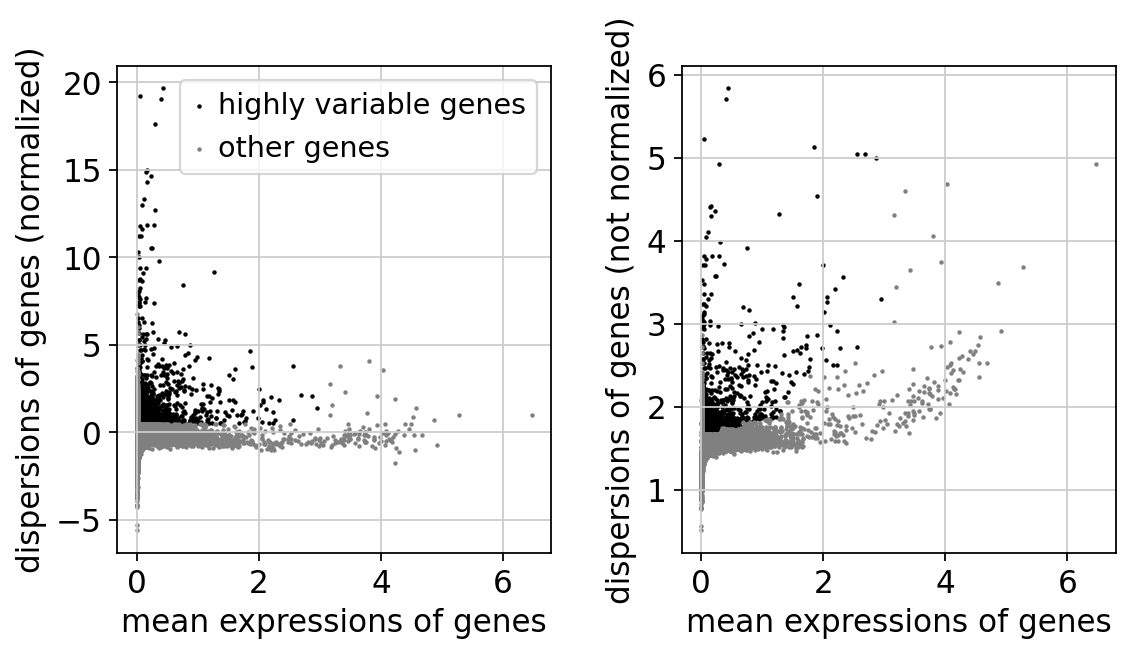

In [125]:
# normalize to 10K counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# log data
sc.pp.log1p(adata)

# get high variance genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# and plot
sc.pl.highly_variable_genes(adata)

# now store the raw version of the data for our use later
adata.raw = adata
adata.write(results_file)


In [126]:
# now process the counts further for doing DE 
# analysis and the cell clustering
adata = adata[:, adata.var.highly_variable]

# regress out the signal
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# scale the genes
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:28)


## PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


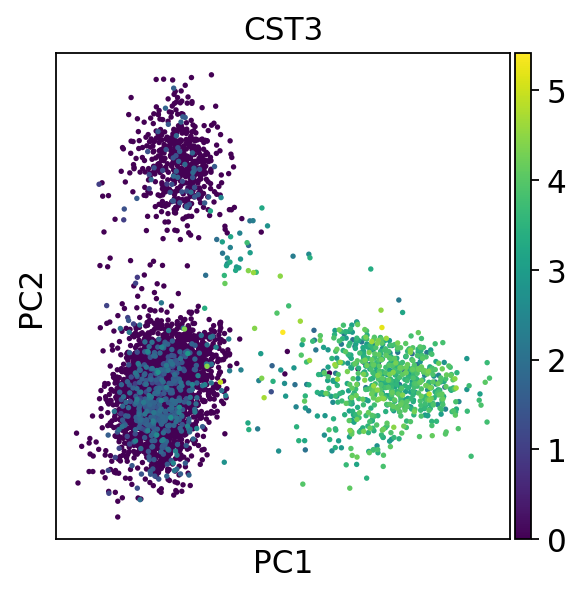

In [127]:
sc.tl.pca(adata, n_comps=50)
sc.pl.pca(adata, color='CST3')


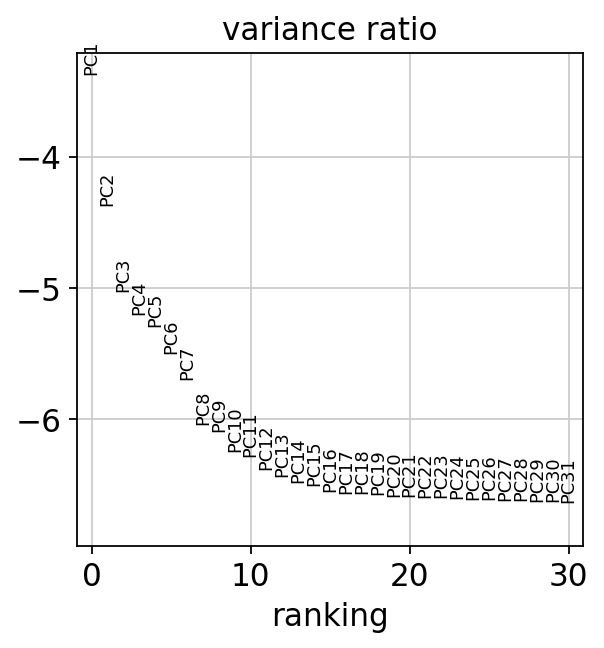

In [128]:
sc.pl.pca_variance_ratio(adata, log=True)


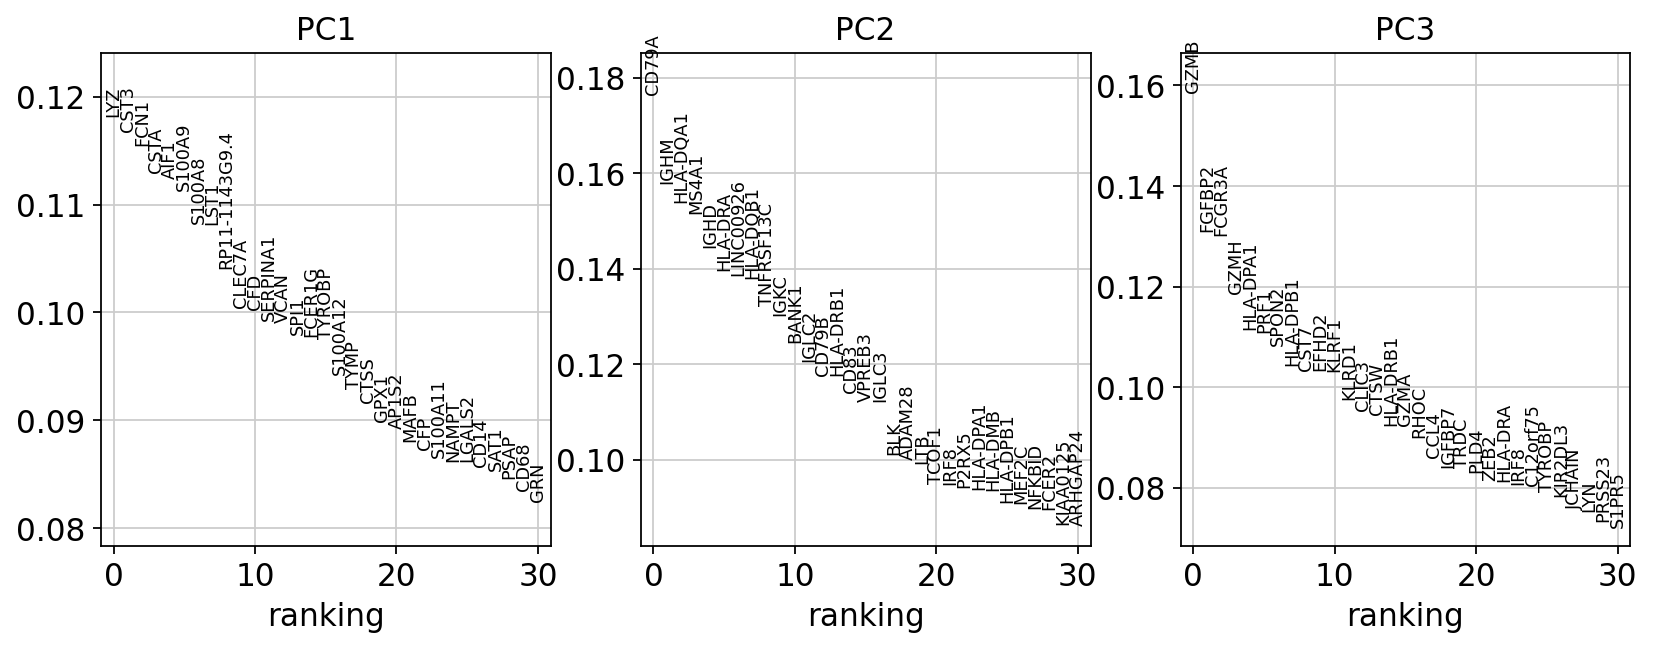

In [129]:
sc.pl.pca_loadings(adata, include_lowest=False)


In [130]:
# save results
adata.write(results_file)


## Compute and embed neighborhood graph

In [131]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


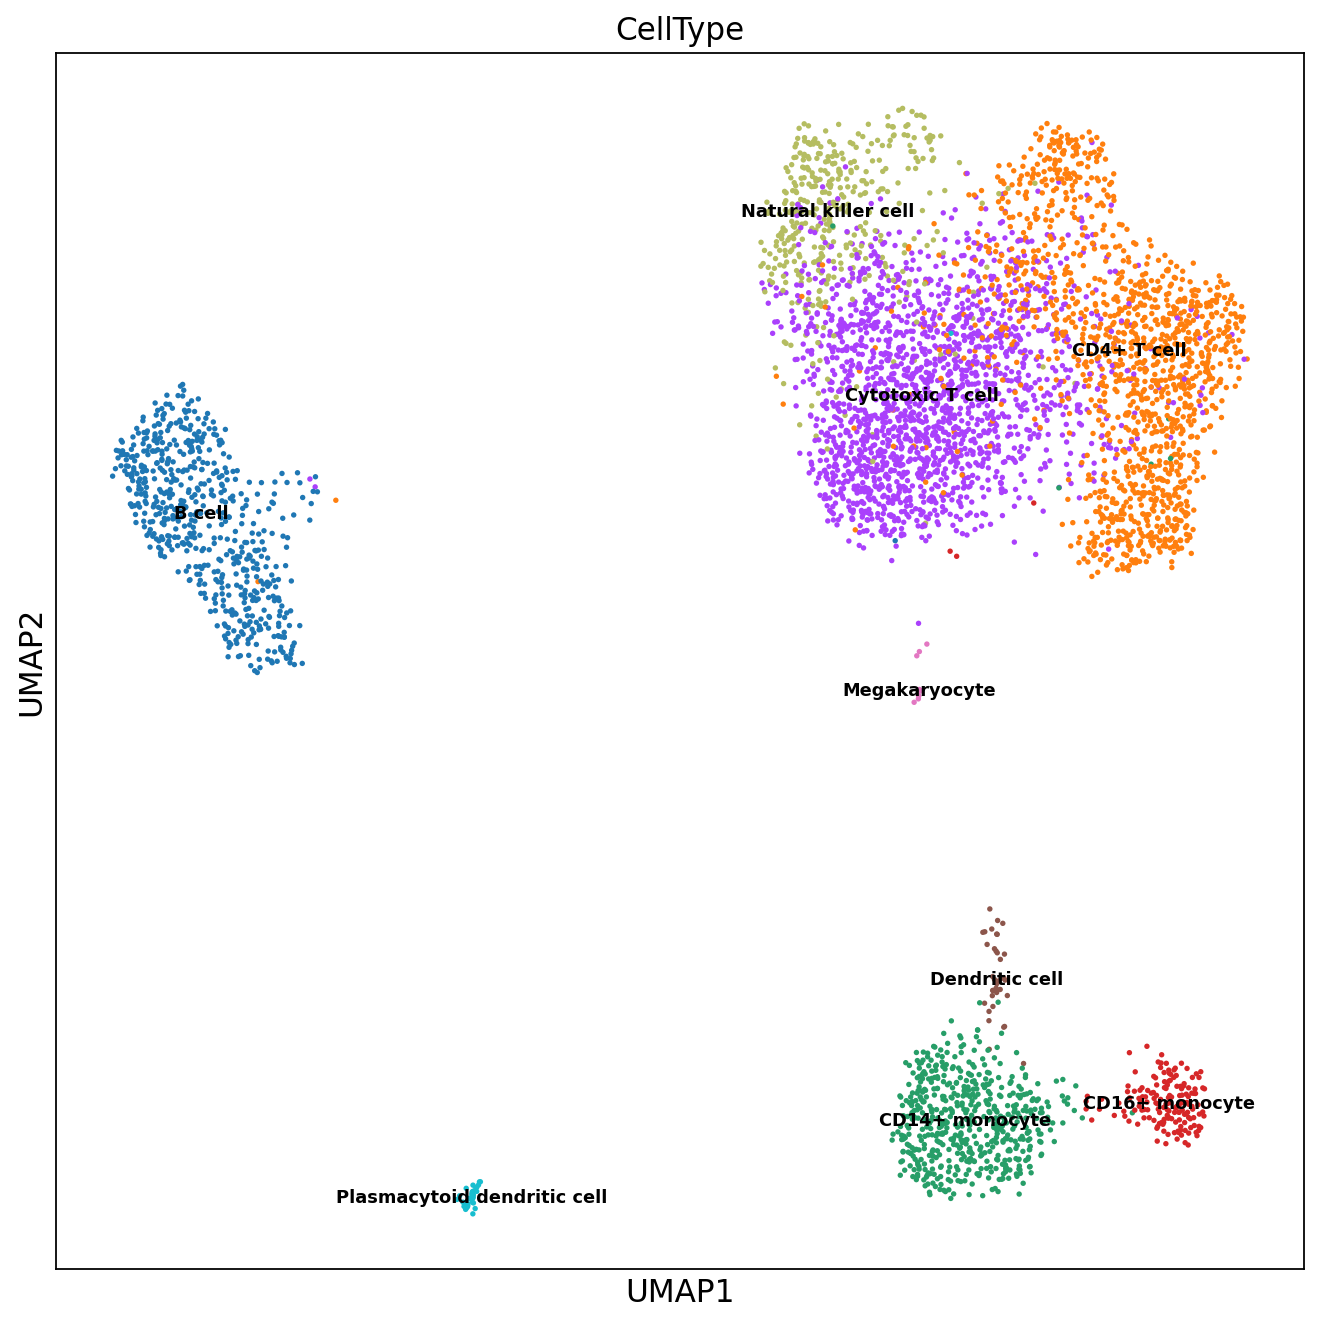

In [132]:
# plot some markers of the RAW data
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, legend_loc='on data', color='CellType', legend_fontsize=8)

## Cluster the neighborhood graph

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


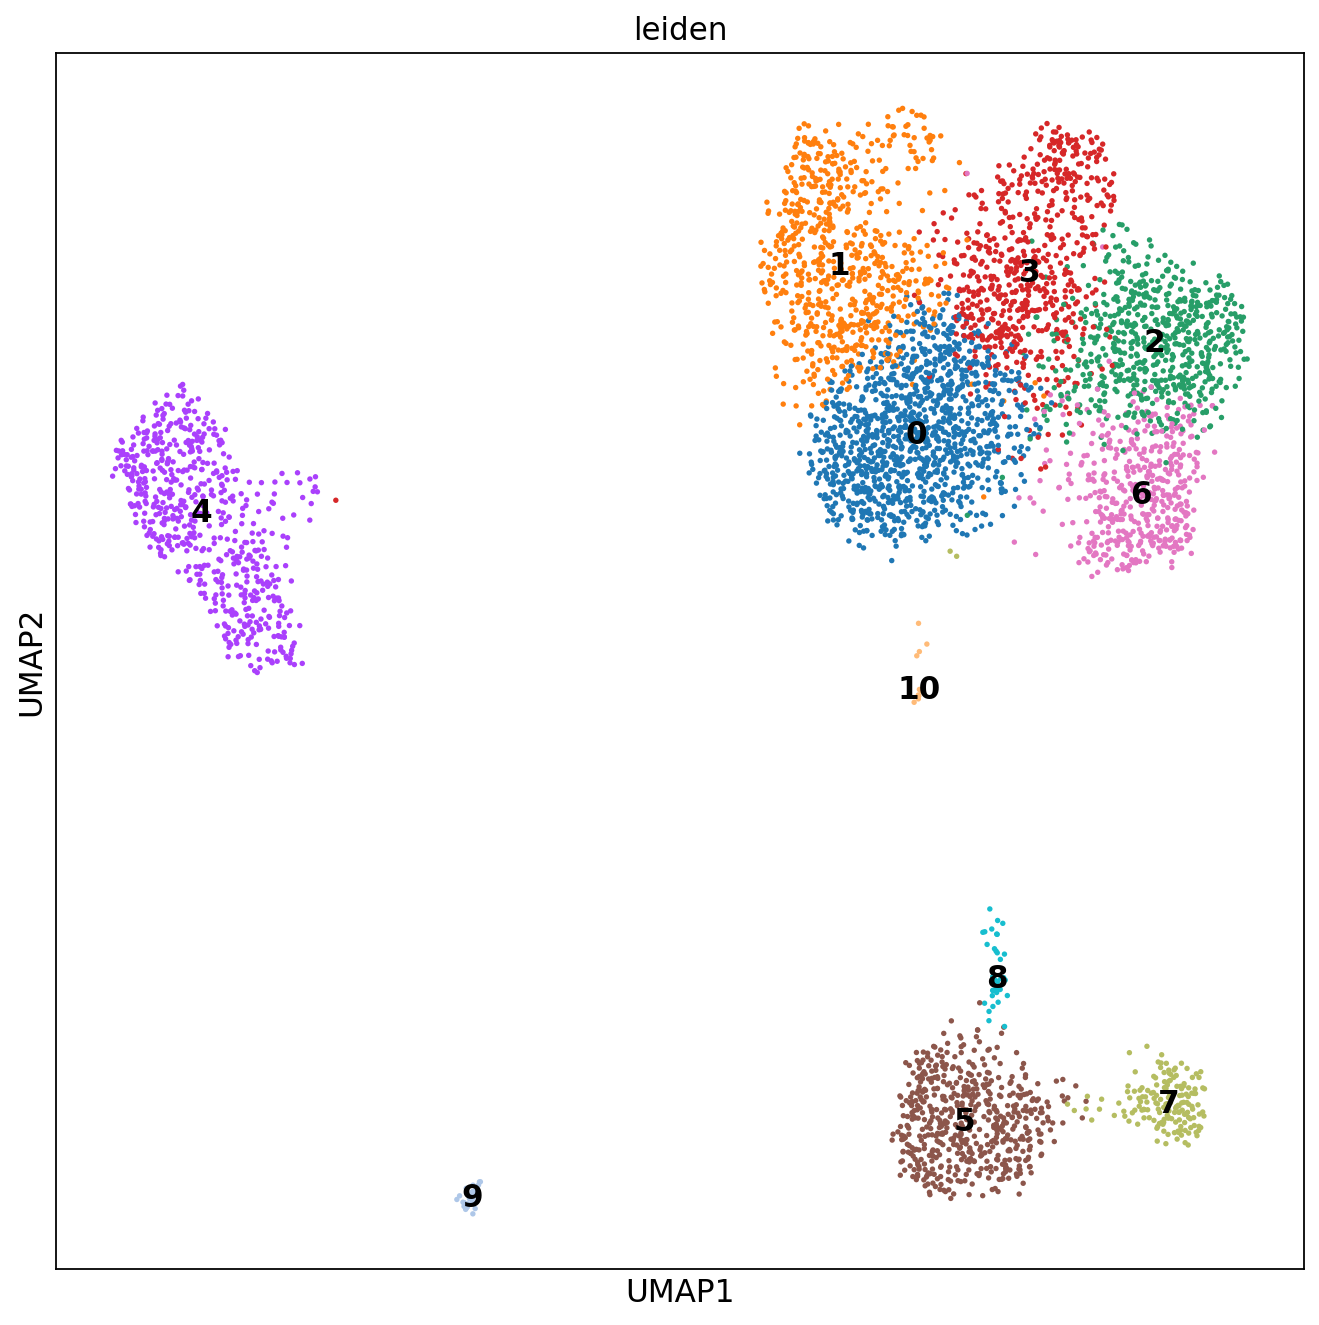

In [133]:
# lets use Leiden clustering
sc.tl.leiden(adata, resolution=1.25)
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color='leiden', legend_loc='on data')

# save
adata.write(results_file)


# merge cell type labels

In [134]:
# make merged cell type predictions
cell_dict = {'Cytotoxic T cell': ['0'], 'CD4+ T cell': ['2'], 'Natural killer cell': ['1'], 'B cell': ['4'], 'CD14+ monocyte': ['5'],
    'CD16+ monocyte': ['7'], 'Dendritic cell': ['8']}


# Initialize empty column in cell metadata
adata.obs['merged'] = np.nan

# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'merged'] = i




... storing 'merged' as categorical


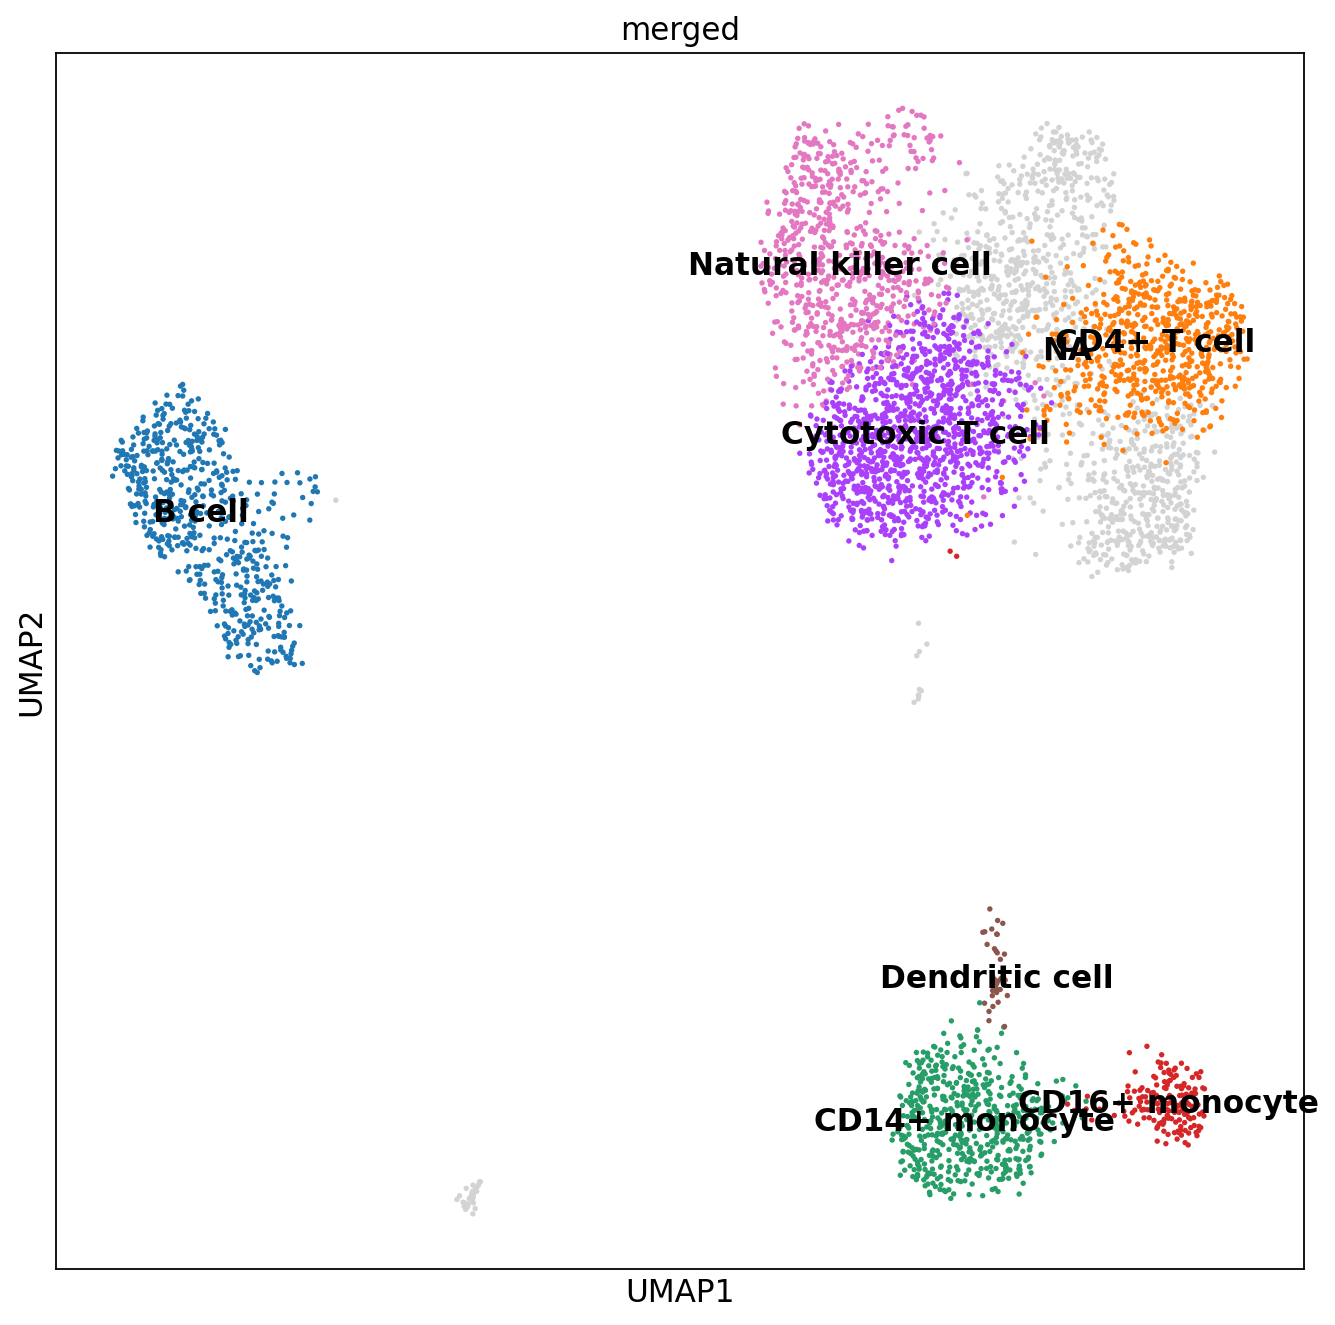

In [135]:
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(adata, color='merged', legend_loc='on data')

# save
adata.write(results_file)

In [138]:
# write out how many of each cell type are found in both and each
adata.obs['merged'] = adata.obs.merged.astype(str)

celltype_consistent = adata.obs['merged'][adata.obs['merged'] == adata.obs['CellType']]
frequency = collections.Counter(celltype_consistent)
print("Freq. of Cell type  consistent between publication and clustering")
print(dict(frequency))

frequency = collections.Counter(adata.obs['CellType'])
print("Freq. of Cell type in publication")
print(dict(frequency))

frequency = collections.Counter(adata.obs['merged'])
print("Freq. of Cell type in clustering")
print(dict(frequency))

Freq. of Cell type  consistent between publication and clustering
{'CD14+ monocyte': 553, 'Dendritic cell': 34, 'B cell': 593, 'Natural killer cell': 372, 'Cytotoxic T cell': 1134, 'CD4+ T cell': 567, 'CD16+ monocyte': 159}
Freq. of Cell type in publication
{'CD14+ monocyte': 562, 'Dendritic cell': 37, 'Cytotoxic T cell': 1879, 'Plasmacytoid dendritic cell': 33, 'B cell': 594, 'Natural killer cell': 397, 'CD4+ T cell': 1376, 'CD16+ monocyte': 161, 'Megakaryocyte': 9}
Freq. of Cell type in clustering
{'CD14+ monocyte': 557, 'Dendritic cell': 35, 'nan': 1146, 'CD16+ monocyte': 162, 'B cell': 596, 'Natural killer cell': 717, 'Cytotoxic T cell': 1186, 'CD4+ T cell': 649}


... storing 'merged' as categorical


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_CellType']`
categories: B cell, CD4+ T cell, CD14+ monocyte, etc.
var_group_labels: CD14 Mono, CD16 Mono, Dendritic, etc.


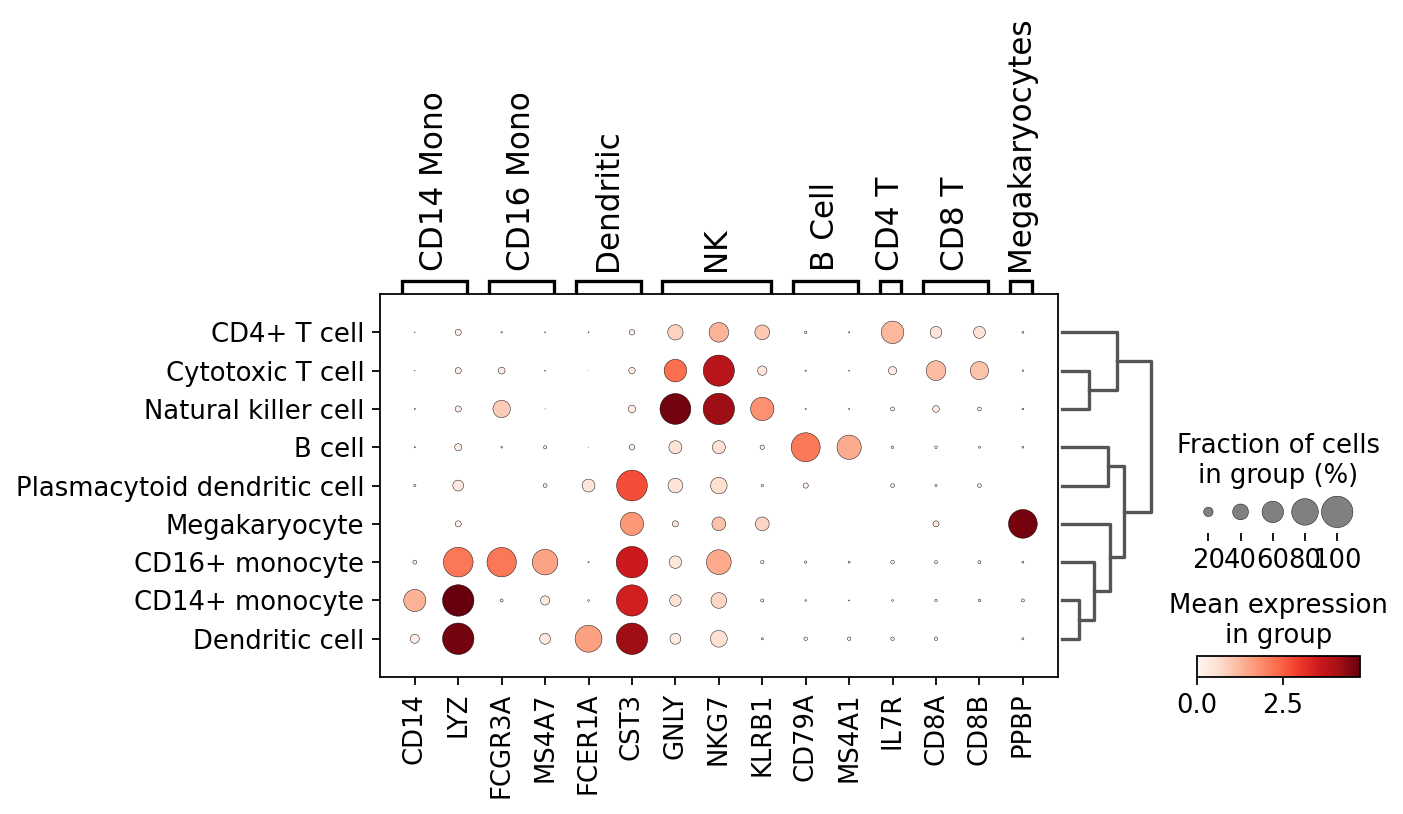

In [139]:
# now as a dotplot show it for all samples
sc.pl.dotplot(adata, marker_genes_dict, groupby='CellType', dendrogram=True)


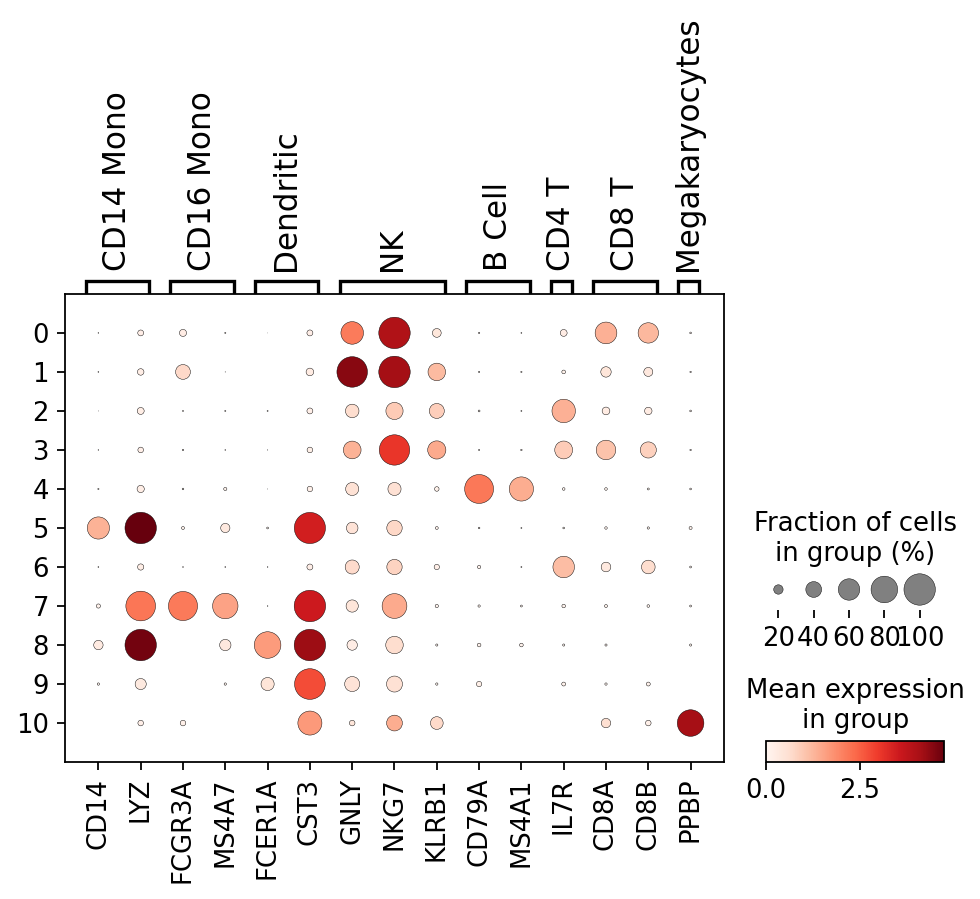

In [140]:
# now as a dotplot show it for all samples
sc.pl.dotplot(adata, marker_genes_dict, groupby='leiden', dendrogram=False)


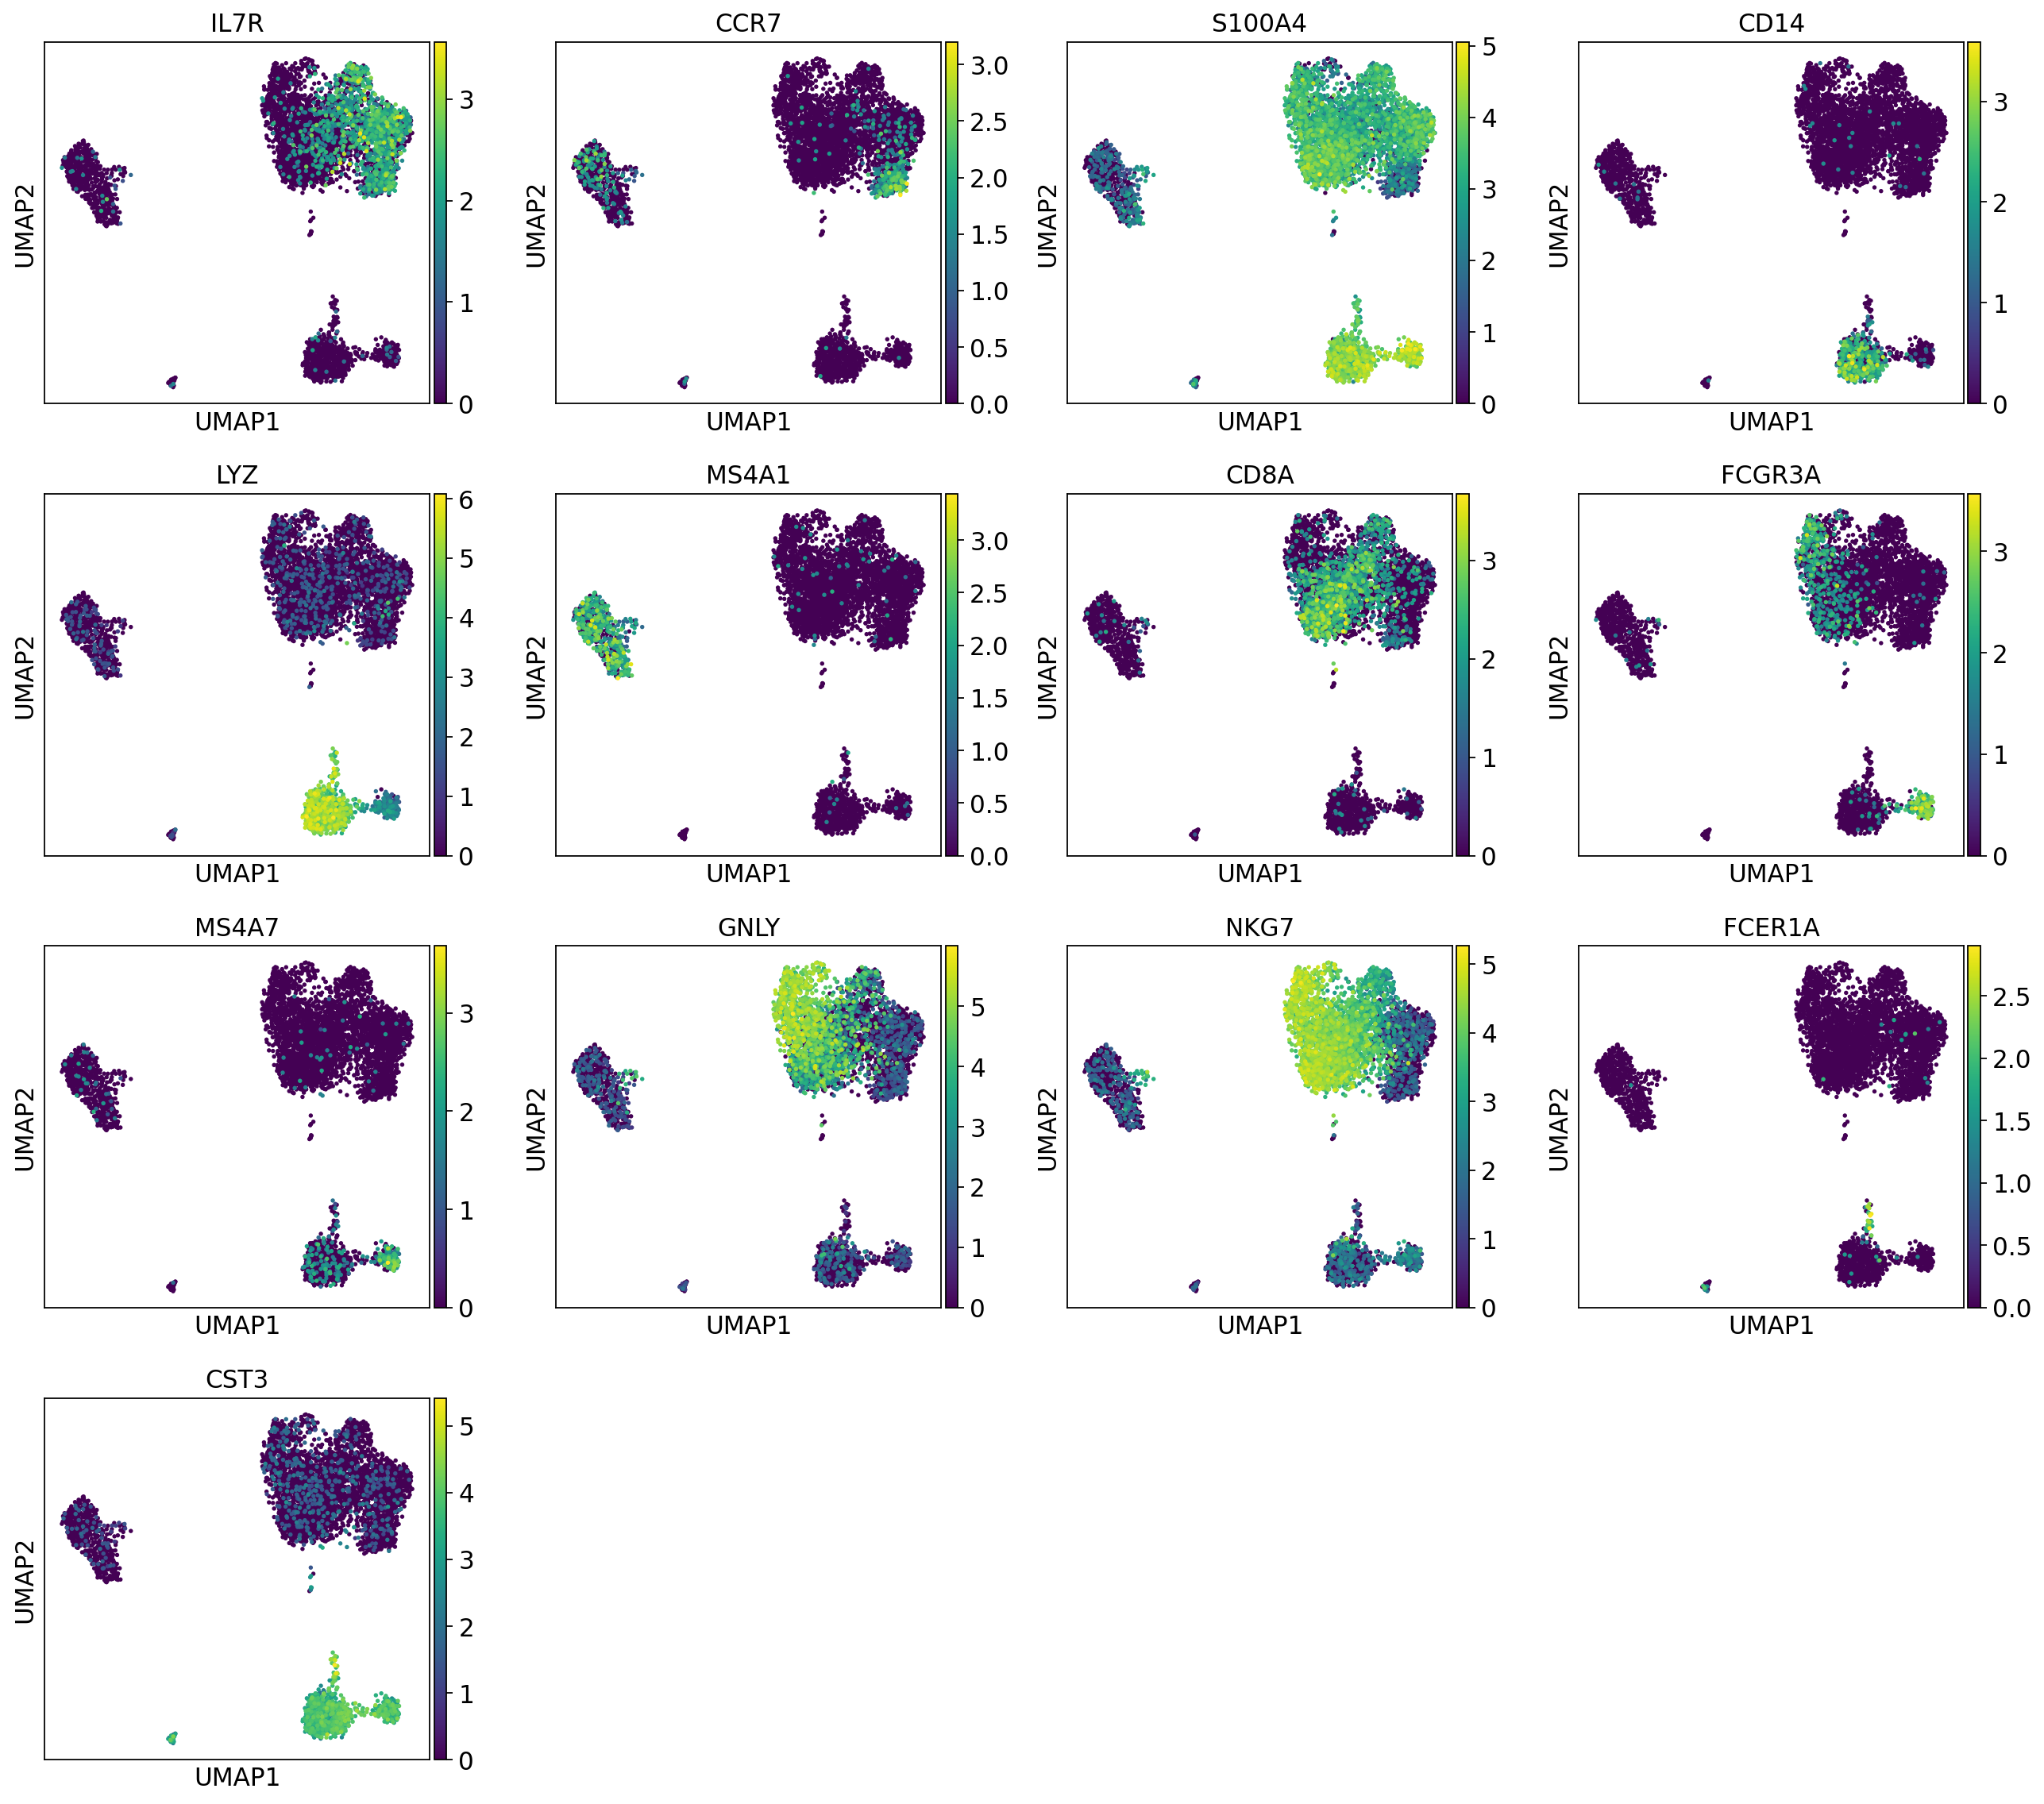

In [141]:
gene_list = ['IL7R', 'CCR7', 'S100A4', 'CD14', 'LYZ', 'MS4A1', 'CD8A',
    'FCGR3A', 'MS4A7', 'GNLY', 'NKG7', 'FCER1A', 'CST3']

sc.pl.umap(adata, color=[i for i in gene_list], color_map='viridis', legend_fontsize=8)

## Find marker genes

ranking genes
    finished (0:00:08)


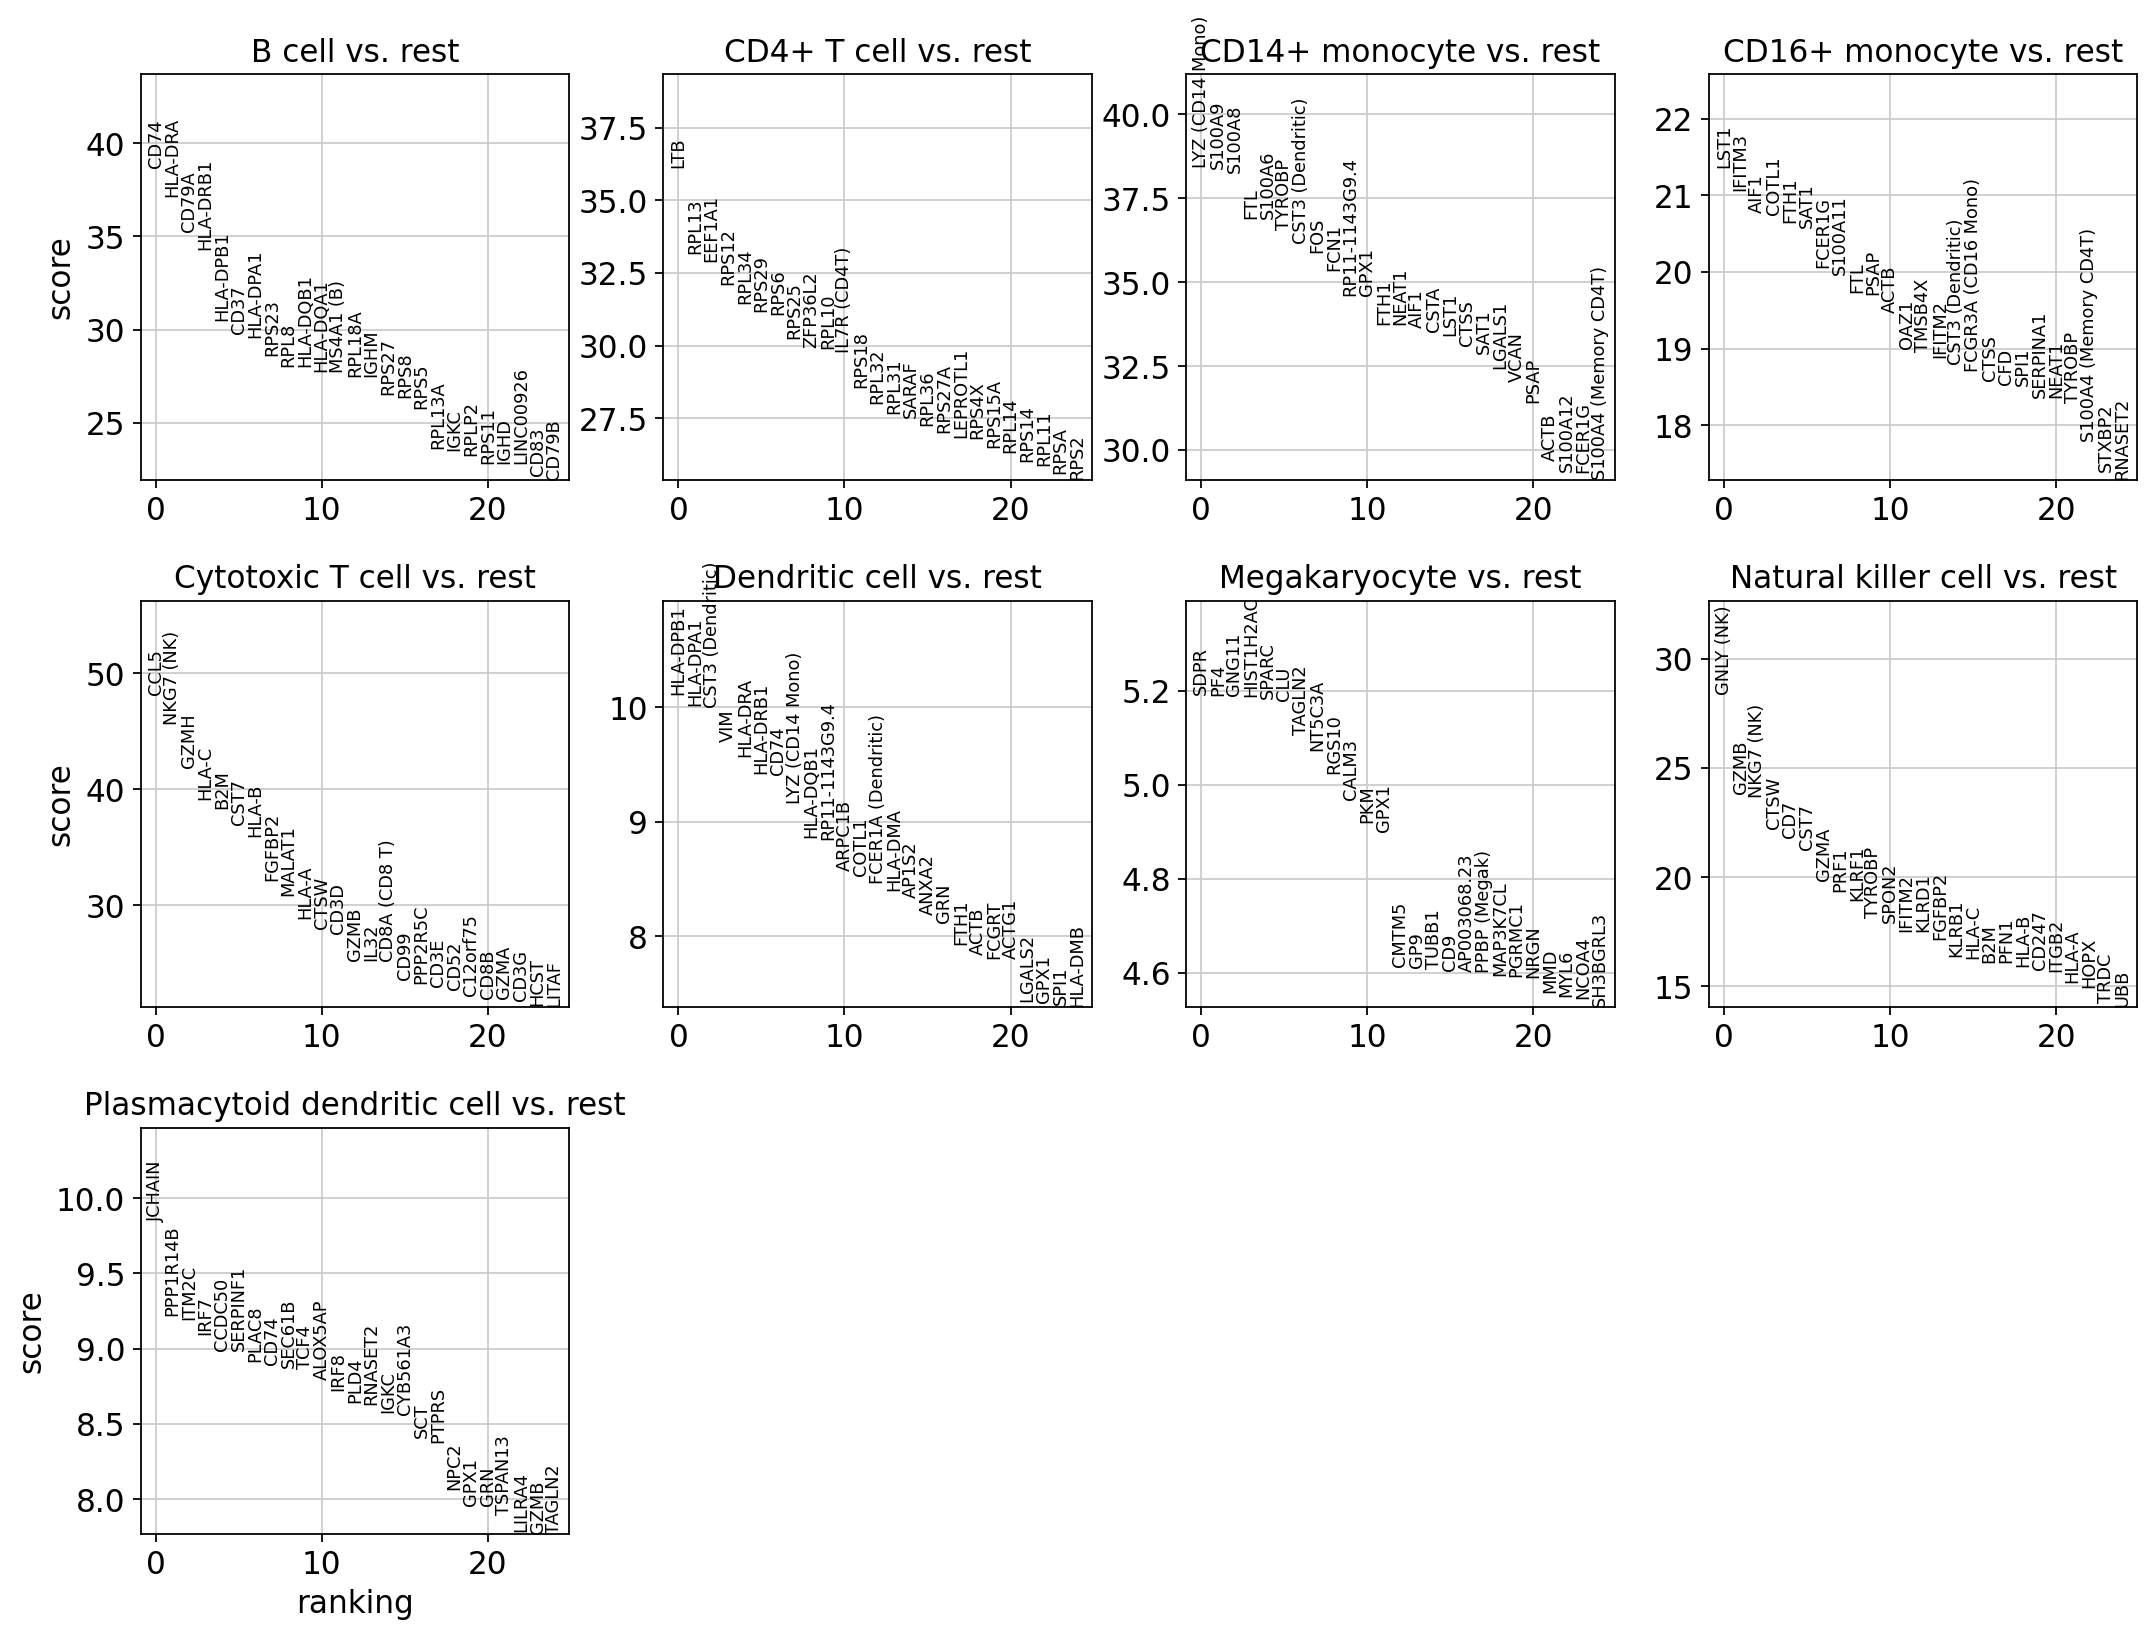

In [147]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(adata, 'CellType', method='wilcoxon') # we will use wilcoxon over t-test
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, gene_symbols="gene_annot")
adata.write(results_file)

ranking genes
    finished (0:00:08)


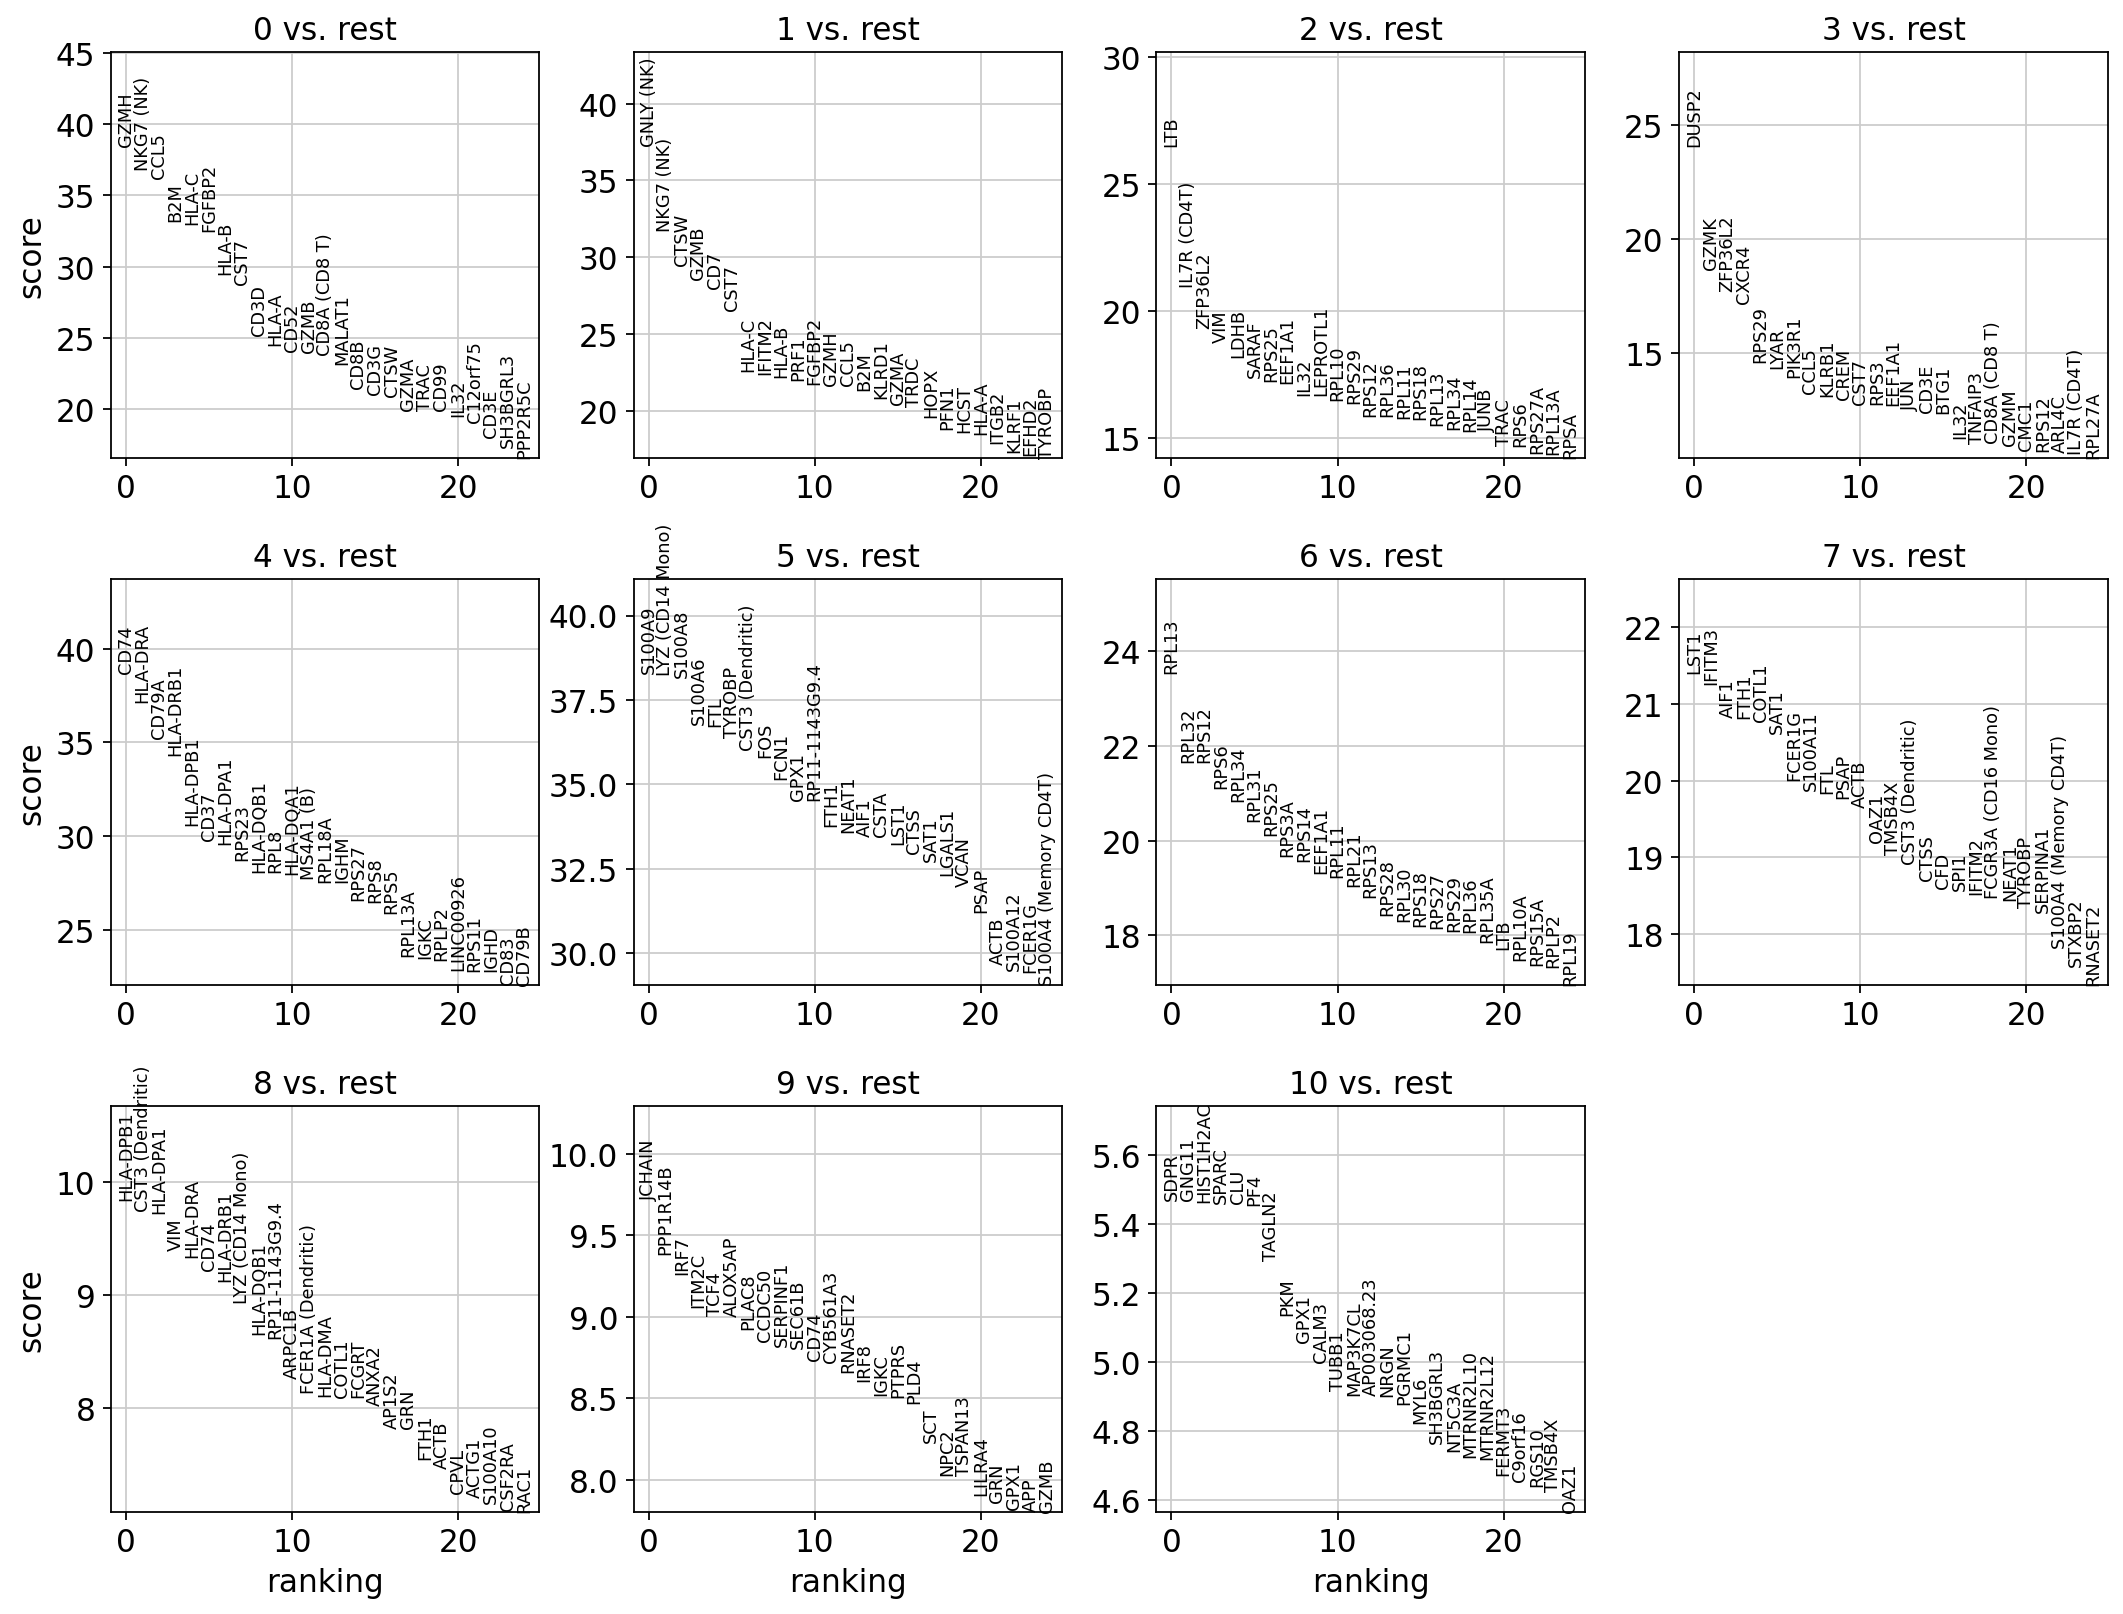

In [142]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon') # we will use wilcoxon over t-test
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, gene_symbols="gene_annot")
adata.write(results_file)


In [143]:
# show top 10 genes per cluster
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)


0     1        2        3         4       5      6       7         8  \
0   GZMH  GNLY      LTB    DUSP2      CD74  S100A9  RPL13    LST1  HLA-DPB1   
1   NKG7  NKG7     IL7R     GZMK   HLA-DRA     LYZ  RPL32  IFITM3      CST3   
2   CCL5  CTSW  ZFP36L2  ZFP36L2     CD79A  S100A8  RPS12    AIF1  HLA-DPA1   
3    B2M  GZMB      VIM    CXCR4  HLA-DRB1  S100A6   RPS6    FTH1       VIM   
4  HLA-C   CD7     LDHB    RPS29  HLA-DPB1     FTL  RPL34   COTL1   HLA-DRA   

          9         10  
0    JCHAIN       SDPR  
1  PPP1R14B      GNG11  
2      IRF7  HIST1H2AC  
3     ITM2C      SPARC  
4      TCF4        CLU

In [144]:
# show p-values
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']})

0_n            0_p     1_n            1_p      2_n            2_p  \
0       GZMH   0.000000e+00    GNLY  1.243883e-303      LTB  8.175141e-155   
1       NKG7  1.604716e-295    NKG7  4.332511e-221     IL7R   3.442238e-97   
2       CCL5  9.639196e-287    CTSW  1.243947e-191  ZFP36L2   2.584275e-83   
3        B2M  1.056486e-241    GZMB  8.555817e-180      VIM   9.602029e-79   
4      HLA-C  9.975986e-239     CD7  2.556930e-172     LDHB   8.087796e-74   
...      ...            ...     ...            ...      ...            ...   
16734   JUNB  8.192339e-107   RPL13   1.527913e-98     CCL5   1.200295e-57   
16735    LTB  4.106533e-108  RPL18A  3.208433e-104     CYBA   2.302708e-62   
16736    FOS  1.136287e-108   RPL34  1.612857e-107     CST7   5.299985e-63   
16737  DUSP1  2.453306e-114   RPL32  3.803946e-111   MT-CO1   3.341689e-63   
16738  RPLP1  1.479648e-115   RPL39  5.024628e-138     NKG7   9.034651e-96   

            3_n            3_p       4_n            4_p  ...     6_n  \
0         DUSP2  4.430666e-128      CD74   0.000000e+00  ...   RPL13   
1          GZMK   5.564941e-78   HLA-DRA  1.313503e-302  ...   RPL32   
2       ZFP36L2   2.809347e-70     CD79A  4.153071e-272  ...   RPS12   
3         CXCR4   1.905430e-66  HLA-DRB1  1.829799e-258  ...    RPS6   
4         RPS29   1.897678e-48  HLA-DPB1  4.081178e-205  ...   RPL34   
...         ...            ...       ...            ...  ...     ...   
16734  HLA-DRB1   4.869151e-24      IL32  2.437360e-174  ...    ACTB   
16735   HLA-DRA   1.584677e-29       B2M  1.994601e-186  ...    NKG7   
16736    TYROBP   7.131795e-31      SRGN  6.690891e-188  ...  S100A4   
16737    LGALS1   4.746687e-56    TMSB4X  1.262210e-199  ...    CYBA   
16738    TMSB10   2.097860e-77    S100A4  6.948439e-221  ...  MT-CO1   

                 6_p     7_n            7_p       8_n           8_p       9_n  \
0      1.536729e-122    LST1  1.111715e-101  HLA-DPB1  7.115829e-23    JCHAIN   
1      4.592022e-104  IFITM3  2.487385e-100      CST3  1.934835e-22  PPP1R14B   
2      4.885640e-104    AIF1   2.267429e-96  HLA-DPA1  2.212233e-22      IRF7   
3       7.036106e-99    FTH1   2.678024e-96       VIM  5.470959e-21     ITM2C   
4       1.900659e-96   COTL1   6.198344e-96   HLA-DRA  1.014297e-20      TCF4   
...              ...     ...            ...       ...           ...       ...   
16734   1.874390e-70  RPL13A   7.570040e-57     RPS29  1.811769e-10      BTG1   
16735   3.040304e-76  RPS27A   2.701109e-60      IL32  6.739098e-11      IL32   
16736   3.807469e-79   RPS18   1.344224e-61       B2M  1.350597e-12   TSC22D3   
16737   9.131324e-86    RPS3   1.765996e-62     RPS27  2.379668e-13    TMSB4X   
16738  1.061559e-110    RPL3   3.185053e-76    MALAT1  1.066453e-15      CD52   

                9_p       10_n          10_p  
0      2.519317e-22       SDPR  4.474057e-08  
1      6.352764e-21      GNG11  4.518138e-08  
2      2.011098e-20  HIST1H2AC  4.675759e-08  
3      1.314768e-19      SPARC  4.681486e-08  
4      2.031336e-19        CLU  4.756557e-08  
...             ...        ...           ...  
16734  3.306349e-09       RPS9  3.234373e-06  
16735  8.778363e-11      RPL30  2.089034e-06  
16736  6.366595e-11      RPS14  1.795900e-06  
16737  1.145399e-11      RPS16  1.530831e-06  
16738  8.626194e-14       RPL9  1.417064e-06  

[16739 rows x 22 columns]

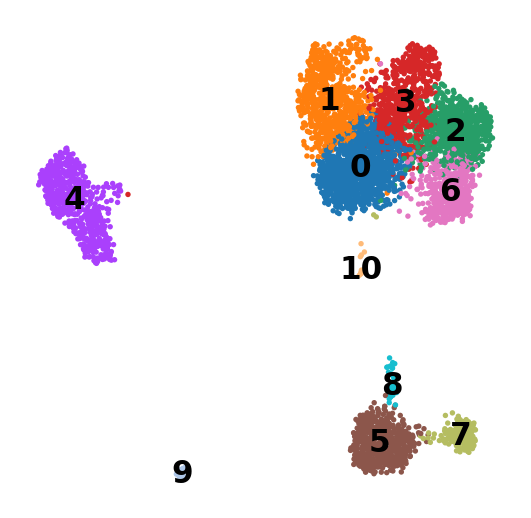

In [145]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf', )


In [146]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading
